### Home work № 8:

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import mannwhitneyu
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                            precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.stats import proportion

In [2]:
marketing_campaign = pd.read_csv('marketing_campaign.csv')
marketing_campaign

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,1/1/18,House Ads,personalization,English,True
1,a1001,1/1/18,House Ads,personalization,English,True
2,a1002,1/1/18,House Ads,personalization,English,True
3,a1003,1/1/18,House Ads,personalization,English,True
4,a1004,1/1/18,House Ads,personalization,English,True
...,...,...,...,...,...,...
10032,a11032,1/17/18,Email,control,German,True
10033,a11033,1/17/18,Email,control,German,True
10034,a11034,1/5/18,Instagram,control,German,False
10035,a11035,1/17/18,Email,control,German,True


Проверяем состав и пропуски:

In [3]:
marketing_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             10037 non-null  object
 1   date_served         10021 non-null  object
 2   marketing_channel   10022 non-null  object
 3   variant             10037 non-null  object
 4   language_displayed  10037 non-null  object
 5   converted           10022 non-null  object
dtypes: object(6)
memory usage: 470.6+ KB


In [4]:
marketing_campaign[marketing_campaign['date_served'].isna() == True]

,user_id,date_served,marketing_channel,variant,language_displayed,converted
7038,a8038,NaN,House Ads,personalization,English,False
9944,a10944,NaN,NaN,control,English,NaN
9945,a10945,NaN,NaN,control,English,NaN
9946,a10946,NaN,NaN,control,English,NaN
9947,a10947,NaN,NaN,control,English,NaN
9948,a10948,NaN,NaN,control,English,NaN
9949,a10949,NaN,NaN,control,English,NaN
9950,a10950,NaN,NaN,control,English,NaN
9951,a10951,NaN,NaN,control,English,NaN
9952,a10952,NaN,NaN,control,English,NaN


In [5]:
marketing_campaign[marketing_campaign['date_served'].isna() == True] = \
marketing_campaign[marketing_campaign['date_served'].isna() == True].fillna({'date_served':'1/15/18',
                                                                             'marketing_channel':'House Ads', 
                                                                             'converted':'True'})

In [6]:
marketing_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             10037 non-null  object
 1   date_served         10037 non-null  object
 2   marketing_channel   10037 non-null  object
 3   variant             10037 non-null  object
 4   language_displayed  10037 non-null  object
 5   converted           10037 non-null  object
dtypes: object(6)
memory usage: 470.6+ KB


In [7]:
marketing_campaign['converted'].value_counts()

False    8946
True     1076
True       15
Name: converted, dtype: int64

In [8]:
marketing_campaign.loc[marketing_campaign['converted'] == 'True', 'converted'] = 1
marketing_campaign.loc[marketing_campaign['converted'] == 'False', 'converted'] = 0

marketing_campaign['converted'] = marketing_campaign['converted'].astype(int)

marketing_campaign['converted'].value_counts(normalize=True)

0    0.891302
1    0.108698
Name: converted, dtype: float64

In [9]:
# разделим данные на train/test
# X_test для А/В
X_train, X_test, y_train, y_test = train_test_split(marketing_campaign.drop(['converted'], axis=1), \
                                                    marketing_campaign['converted'], random_state=42)
# X_val - наш внутренний тест
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42)

In [10]:
# соберем наш pipeline
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


class OHEEncoderBin(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        B = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        self.columns = B[:1]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
    
        return X[self.columns]  

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5645 entries, 9022 to 2961
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             5645 non-null   object
 1   date_served         5645 non-null   object
 2   marketing_channel   5645 non-null   object
 3   variant             5645 non-null   object
 4   language_displayed  5645 non-null   object
dtypes: object(5)
memory usage: 264.6+ KB


In [12]:
X_train.describe()

,user_id,date_served,marketing_channel,variant,language_displayed
count,5645,5645,5645,5645,5645
unique,5645,31,5,2,4
top,a10022,1/15/18,House Ads,control,English
freq,1,442,2664,2859,5522


In [13]:
X_train.head(3)

,user_id,date_served,marketing_channel,variant,language_displayed
9022,a10022,1/12/18,Push,personalization,English
9204,a10204,1/13/18,Push,personalization,English
9742,a10742,1/9/18,Instagram,personalization,English


In [14]:
categorical_col =  ['marketing_channel', 'variant',  'language_displayed']

for i in categorical_col:
    print(i,' число уникальных значений: ', len(pd.unique(X_train[i])), 'уникальные значения', pd.unique(X_train[i]))

marketing_channel  число уникальных значений:  5 уникальные значения ['Push' 'Instagram' 'House Ads' 'Facebook' 'Email']
variant  число уникальных значений:  2 уникальные значения ['personalization' 'control']
language_displayed  число уникальных значений:  4 уникальные значения ['English' 'Spanish' 'Arabic' 'German']


In [15]:
X_train['date_served'] = pd.to_datetime(X_train['date_served']).dt.day

In [16]:
X_train.head(3)

,user_id,date_served,marketing_channel,variant,language_displayed
9022,a10022,12,Push,personalization,English
9204,a10204,13,Push,personalization,English
9742,a10742,9,Instagram,personalization,English


In [17]:
categorical_columns = ['marketing_channel', 'language_displayed', 'date_served']
# continuous_columns = ['date_served']
categorical_bin_columns = ['variant']

variant = Pipeline([
                ('selector', FeatureSelector(column='variant')),
                ('ohe', OHEEncoderBin(key='variant'))
            ])

variant.fit(X_train)
variant.transform(X_test).head(3)

,variant_control
9729,0
6618,0
4441,1


In [18]:
final_transformers = list()
for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
for bin_col in categorical_bin_columns:
    bin_transformer = Pipeline([
                ('selector', FeatureSelector(column=bin_col)),
                ('ohe', OHEEncoderBin(key=bin_col))
            ])
    final_transformers.append((bin_col, bin_transformer))

In [19]:
final_transformers

[('marketing_channel',
  Pipeline(steps=[('selector', FeatureSelector(column='marketing_channel')),
                  ('ohe', OHEEncoder(key='marketing_channel'))])),
 ('language_displayed',
  Pipeline(steps=[('selector', FeatureSelector(column='language_displayed')),
                  ('ohe', OHEEncoder(key='language_displayed'))])),
 ('date_served',
  Pipeline(steps=[('selector', FeatureSelector(column='date_served')),
                  ('ohe', OHEEncoder(key='date_served'))])),
 ('variant',
  Pipeline(steps=[('selector', FeatureSelector(column='variant')),
                  ('ohe', OHEEncoderBin(key='variant'))]))]

Добавляем классификатор:

In [20]:
feats = FeatureUnion(final_transformers)

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

In [21]:
# обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('marketing_channel',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='marketing_channel')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='marketing_channel'))])),
                                                ('language_displayed',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='language_displayed')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='language_displayed'))])),
                                                ('date_served',
                        

In [22]:
# наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_val)[:, 1]
preds[:10]

array([0.03128064, 0.02036616, 0.09734359, 0.00425   , 0.04054495,
       0.03128064, 0.66429445, 0.02036616, 0.15379045, 0.03128064])

Калибруем модель:

In [23]:
precision, recall, thresholds = precision_recall_curve(y_val, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.097344, F-Score=0.341, Precision=0.237, Recall=0.606


In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1230  431]
 [  87  134]]


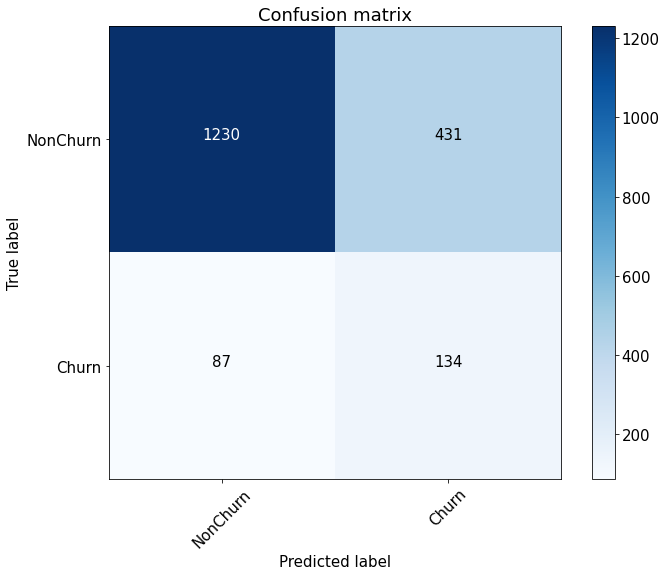

In [25]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_val, preds >= thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [26]:
# Конверсия

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

C0 = (TP + FN) / np.sum(cnf_matrix)
C0

0.11742826780021254

Начинаем A/B тест:

базовая конверсия 0.214

Разбиваем тестовый набор на 2 группы: контрольную и рабочую:

In [27]:
X_test.shape

(2510, 5)

In [28]:
X_A, X_B, y_A, y_B = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

Применяем модель к группе В:

In [29]:
predsB = pipeline.predict_proba(X_B)[:, 1]
cnf_matrix = confusion_matrix(y_B, predsB > thresholds[ix])

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
print(cnf_matrix)

[[857 257]
 [ 60  81]]


In [30]:
churn_ef = 0.5  # Снижение эффективности предсказания за счет не полного действия мер по борьбе
C0_A = (np.sum(y_A)) / y_A.shape[0] # churn rate без ML
print(C0_A)
C1_MLB = (FN + (1-churn_ef) * TP) / np.sum(cnf_matrix) # churn rate при ML
print(C1_MLB)

0.10438247011952191
0.0800796812749004


видим улучшения при использовании модели

In [31]:
y_churnA = y_A

y_pred = (predsB > thresholds[ix])
ind_churn = np.where((y_pred != y_B) & (y_B == 1))
y_churnB = np.zeros(y_B.shape)
y_churnB[ind_churn] = 1


k1, n1 = np.sum(y_A), y_A.shape[0]
k2, n2 = np.sum(y_churnB), y_churnB.shape[0]
k1, k2, n1, n2

(131, 60.0, 1255, 1255)

In [32]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                 np.array([n1, n2]))

print(f'Results are z_score={z_score:.3f} pvalue={z_pvalue:.3f}')

Results are z_score=5.345 pvalue=0.000


In [33]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                        np.array([n1, n2]))

print(f'Results are chisq={chisq:.3f} pvalue={pvalue:.3f}')

Results are chisq=28.566 pvalue=0.000


Модель работает хорошо